# Ising fitter for capped homopolymer repeat proteins.

Authors:  Doug Barrick, Jacob D. Marold, Kathryn Geiger-Schuller, Tural Aksel, Ekaterina Poliakova-Georgantas, Sean Klein, Kevin Sforza, Mark Peterson

This notebook reads data from Aviv data files, converts the data to normalized unfolding transitions, generates partition functions and expressions for fraction folded, and uses these expressions to fit the normalized transitions.  Data and fits are plotted in various ways, and bootstrap analysis is performed.  Correlation plots are generated for pairs of bootstrap parameter values.

## Imports, path, and project name

Path and project name should be set by the user.  Note that because of the kernel restart below, these must be specified in subsequent scripts, along with any other imports that are needed.

In [1]:
import numpy as np
import ntpath   
import glob     
import csv
import json
import time
import pandas as pd

path = '/Users/dougbarrick/OneDrive - Johns Hopkins/Manuscripts/Ising_program/\
Scripts/scripts_vanilla_NRC/cANK_scripts/cANK_jupyter_scripts/'

proj_name = 'cANK'

## Data conversion.

Data are read from an Aviv.dat file.

Outputs are

1.  A numpy data file for each melt, contining [denaturant], normalized signal, construct ID, and melt ID.

2.  A list of constructs.

3.  A list of melts.

In [18]:
start = time.time()

den_nsig_const_melt = []
constructs = []         # List of constructs used to build partition functions and
                        # frac_folded expressions in next script.
melts = []              # List of melts to be used in fitting.

# Create an empty pandas dataframe to output a csv file from.
den_nsig_const_melt_df = pd.DataFrame(columns=['denat','signal','construct_melt','dataset'])

# Gets file names, and extracts information including construct name, melt number.
num = 0        
for filename in glob.glob('{}*.dat'.format(path)):
    num = num + 1
    base = ntpath.basename(filename)
    melt = base.split(".")[0]
    construct = melt[:-2]

# Reads the data portion of Aviv file, sticks it in a list, then normalizes
# the y values and writes out a data file including construct and
# a melt number to use as an ID for fitting in ising script.
    with open(filename, 'r') as f: 
        lines = f.read().splitlines() #define the beginning and end of the data
        begin = 0
        end = 0
        while not lines[begin] == '$DATA':
            begin = begin + 1
        begin = begin + 4    
        while not lines[end] == '$ENDDATA':
            end = end + 1    
        xylist = []
        xyarray = []
        for row in range(begin, end - 1):  #extract the [denat] and CD signal
            line = lines[row]
            n = line.split()
            xylist.append([float(n[0]), float(n[1])])
        xyarray = np.array(xylist)

# Below, the data is normalized.                          
        maxval = max(xyarray[:,1])
        minval = min(xyarray[:,1])
        normylist = []
        for i in range(0,len(xyarray)):
            normy = float(((xyarray[i,1] - maxval)/(minval - maxval)))
            normylist.append(normy)      
        for i in range(0, len(xylist)): 
            den_nsig_const_melt.append([xyarray[i,0], normylist[i], construct, num])

# Build a numpy array for each melt and output for Ising fitter.  
# Columns are denaturant, normalized CD, construct, melt number.
        single_melt_dncm = []
        for i in range(0, len(xylist)): 
            single_melt_dncm.append([xyarray[i,0], normylist[i], construct, num])
        melt_array = np.array(single_melt_dncm)
        np.save(path + melt, melt_array) # Writes an npy file to disk for each melt.
        temp_df = pd.DataFrame(melt_array)
        den_nsig_const_melt_df = den_nsig_const_melt_df.append(temp_df)
        if construct not in constructs: 
            constructs.append(construct)
        melts.append(melt)        

den_nsig_const_melt_df.to_csv('{}{}_combined_data.csv'.format(path, proj_name), index=False, header=False)
        
''' 
This loop puts melts in order of type (NRxC, NRx, RxC) and length.  This is useful for the
plotting script below, putting the by_melt legends in a sensible order
'''
NRClist = []
NRlist = []
RClist = []
melts.sort()  # Puts in order based on length
i = 0
for melt in melts:
    if melt[0] == 'N':
        if melt[-3] == 'C':
            NRClist.append(melt)
        else:
            NRlist.append(melt)
    else:
        RClist.append(melt)
melts = NRClist + NRlist + RClist

# This loop generates a construct list in the same order as the melts list.
for melt in melts:
    construct = melt[:-2]
    if construct not in constructs: 
        constructs.append(construct)
    
# Write out the results.  
with open("{0}{1}_constructs.txt".format(path, proj_name), 'wb') as r:
    json.dump(constructs, r)

with open("{0}{1}_melts.txt".format(path, proj_name), 'wb') as s:
    json.dump(melts, s)  

stop = time.time()
runtime = stop - start
print('\nThe elapsed time was ' + str(runtime) + ' sec')        


The elapsed time was 0.0476260185242 sec


In [7]:
temp_df

,0,1,2,3
0,0.5,0.971889550083,N_R_R,18
1,0.7,0.973756940468,N_R_R,18
2,0.9,0.980230560466,N_R_R,18
3,1.1,0.98501107985,N_R_R,18
4,1.3,0.988372382541,N_R_R,18
5,1.5,0.993725568309,N_R_R,18
6,1.7,0.995667654309,N_R_R,18
7,1.9,0.998954261385,N_R_R,18
8,2.1,0.999850608769,N_R_R,18
9,2.3,1.0,N_R_R,18


In [15]:
den_nsig_const_melt_df

,0,1,2,3,construct_melt,dataset,denat,signal
0,1.93,0.968495672394,R_R_R_R_C,1,NaN,NaN,NaN,NaN
1,2.13,0.973388451105,R_R_R_R_C,1,NaN,NaN,NaN,NaN
2,2.33,0.974680273866,R_R_R_R_C,1,NaN,NaN,NaN,NaN
3,2.53,0.978878697843,R_R_R_R_C,1,NaN,NaN,NaN,NaN
4,2.73,0.983513112001,R_R_R_R_C,1,NaN,NaN,NaN,NaN
5,2.93,0.988567368557,R_R_R_R_C,1,NaN,NaN,NaN,NaN
6,3.13,0.993427851699,R_R_R_R_C,1,NaN,NaN,NaN,NaN
7,3.33,0.995187960212,R_R_R_R_C,1,NaN,NaN,NaN,NaN
8,3.53,0.997416354476,R_R_R_R_C,1,NaN,NaN,NaN,NaN
9,3.73,1.0,R_R_R_R_C,1,NaN,NaN,NaN,NaN


In [13]:
den_nsig_const_melt_df.append(temp_df)

,denat,signal,construct_melt,dataset
0,0.5,0.971889550083,N_R_R,18
1,0.7,0.973756940468,N_R_R,18
2,0.9,0.980230560466,N_R_R,18
3,1.1,0.98501107985,N_R_R,18
4,1.3,0.988372382541,N_R_R,18
5,1.5,0.993725568309,N_R_R,18
6,1.7,0.995667654309,N_R_R,18
7,1.9,0.998954261385,N_R_R,18
8,2.1,0.999850608769,N_R_R,18
9,2.3,1.0,N_R_R,18


## Generate a partition function and fraction folded expressions for fitting.

Inputs the constructs.txt, melts.txt, and processed .npy data files from the data processing script above.

Generates a dictionary of partition functions using the capped homopolymer 1D-Ising model, and converts these to dictionaries of fraction-folded expressions (**fraction_folded_dict**) for fitting by partial differentiation.  Manipulations are done using the sympy module which allows symbolic math operations.  This is important for partial differentiation, but also for "simplification" of the fraction folded exprssions.  This simplification factors common terms, significantly decreasing the time it takes to fit and bootstrap below.  The fraction-folded dictionary is exported in json format.

Because the numpy exponential function (np.exp) gets reassigned in this script, and I cannot figure out how to undo this, the kernel must be restarted at the bottom of the script (exit()).  The user will be prompted to accept.

Though the path, project name, and most (but not all imports) are redundant with the command above, the kernel restart at the end of this script can create problems, if the script is run more than once.  For this reason I am keeping them associated with this script (and with subsequent scripts--fitting, plotting, etc).

Note that on 2020_05_05, I am changing the equation that gives the denaturant dependence of DGi to DGi + mi denat in the three equations for N, R, and C.  This corresponds to a positive m-value (free energies become more positive with denaturant).  Also change initial guess in the fitting cell.

In [3]:
from __future__ import division
import sympy as sp
import numpy as np
import json
import time

path = '/Users/dougbarrick/OneDrive - Johns Hopkins/Manuscripts/Ising_program/\
Scripts/scripts_vanilla_NRC/cANK_scripts/cANK_jupyter_scripts/'

proj_name = 'cANK'

start = time.time()

print('Generating partition functions and fraction folded expressions.  This may take a minute...')

# Parameters for partition function calculation.  Note these are sympy symbols.
RT = sp.Symbol('RT')
dGN = sp.Symbol('dGN')
dGR = sp.Symbol('dGR')
dGC = sp.Symbol('dGC')
mi = sp.Symbol('mi')
denat = sp.Symbol('denat')
Kn = sp.Symbol('Kn')
Kr = sp.Symbol('Kr')
Kc = sp.Symbol('Kc')
dGinter = sp.Symbol('dGinter')
W = sp.Symbol('W')

np.exp = sp.Function('np.exp')

with open('{0}{1}_constructs.txt'.format(path, proj_name)) as cons:
    constructs = json.load(cons)

#define matricies  and end vectors to be used to calculate partition functions
begin = sp.Matrix([[0,1]])
N = sp.Matrix([[(Kn*W),1],[Kn,1]])
R = sp.Matrix([[(Kr*W),1],[Kr,1]])
C = sp.Matrix([[(Kc*W),1],[Kc,1]])
end = sp.Matrix([[1],[1]])

# Build dictionaries of partition functions, partial derivs with respect
# to K, and fraction folded.

q_dict = {}
dqdKn_dict = {}
dqdKr_dict = {}
dqdKc_dict = {}
frac_folded_dict = {}

# Number of repeats of each type.  Seems like they should be floats, but
# I get an error in the matrix multiplication (q_dict) if they are declared to be.

for construct in constructs:

    # Make partition function dictionary and expressions for fraction folded. 
    # Note, only one pf is generated per construct, even when there are multiple melts.
    
    matrixlist = construct.split('_')
    q_dict[construct + '_q'] = begin 
        
    for i in range(0,len(matrixlist)):
        num_Ni = 0
        num_Ri = 0
        num_Ci = 0
        if matrixlist[i] == 'N':
            num_Ni=1
        if matrixlist[i] == 'R':
            num_Ri=1
        if matrixlist[i] == 'C':
            num_Ci=1

        q_dict[construct + '_q'] = q_dict[construct + '_q'] *\
        np.linalg.matrix_power(N, num_Ni) * np.linalg.matrix_power(R, num_Ri) *\
        np.linalg.matrix_power(C, num_Ci) 
      
    q_dict[construct + '_q'] =  q_dict[construct + '_q'] * end

    # Next two lines convert from sp.Matrix to np.array to something else.
    # Not sure the logic here, but it works.
    
    q_dict[construct + '_q'] = np.array(q_dict[construct + '_q']) 
    q_dict[construct + '_q'] = q_dict[construct + '_q'].item(0)

    # Partial derivs wrt Kn dictionary.
    dqdKn_dict[construct + '_dqdKn'] \
        = sp.diff(q_dict[construct + '_q'], Kn)

    # Partial derivs wrt Kr dictionary.
    dqdKr_dict[construct + '_dqdKr'] \
        = sp.diff(q_dict[construct + '_q'], Kr)

    # Partial derivs wrt Kc dictionary.
    dqdKc_dict[construct + '_dqdKc'] \
        = sp.diff(q_dict[construct + '_q'], Kc)

    # Fraction folded dictionary.  
    frac_folded_dict[construct + '_frac_folded'] \
        = (Kn/( q_dict[construct + '_q']) * dqdKn_dict[construct + '_dqdKn'] \
        + Kr/(q_dict[construct + '_q']) * dqdKr_dict[construct + '_dqdKr'] \
        + Kc/( q_dict[construct + '_q']) * dqdKc_dict[construct + '_dqdKc']) \
        / (len(matrixlist))

# The loop below replaces K's and W's the fraction folded terms in the 
# dictionary with DGs, ms, and denaturant concentrations.  The simplify line
# is really important for making compact expressions for fraction folded.
# This simplification greatly speeds up fitting.  The last line
# converts from a sympy object to a string, to allow for json dump.

for construct in frac_folded_dict:
    frac_folded_dict[construct] = frac_folded_dict[construct].subs({
    Kn:(np.exp(-((dGN + (mi*denat))/RT))), 
    Kr:(np.exp(-((dGR + (mi*denat))/RT))), 
    Kc:(np.exp(-((dGC + (mi*denat))/RT))),  
    W:(np.exp(-dGinter/RT)) }) 
    frac_folded_dict[construct] = sp.simplify(frac_folded_dict[construct])
    frac_folded_dict[construct] = str(frac_folded_dict[construct])                                

with open('{0}{1}_frac_folded_dict.txt'.format(path, proj_name), 'wb') as f:
    json.dump(frac_folded_dict, f)

'''
The exit statement below quits the kernel, which is required before the Ising
fitter is run (presumably because np.exp gets reassigned, and I am not sure
how to un-assign it).  The only disadvantage to this approach is that you 
will not be able to inspect the output of the present script (and the fraction
folded dictionary in particular).  If you need to see these results, comment
out the exit command, and uncomment the warning print statement, so you don't
forget to restart the kernel before fitting.
'''
   
stop = time.time()
runtime = stop - start
print('\nThe elapsed time was ' + str(runtime) + ' sec') 

print('\n')
print('''The kernel is about to restart to avoid errors associated with the
reassignment of np.exp above, which inteferes with the Ising fitter.  If you
need to see the variable space that results from running this script, comment
out the exit() command below.''')
time.sleep(6)
exit()    


Generating partition functions and fraction folded expressions.  This may take a minute...

The elapsed time was 31.6358878613 sec


The kernel is about to restart to avoid errors associated with the
reassignment of np.exp above, which inteferes with the Ising fitter.  If you
need to see the variable space that results from running this script, comment
out the exit() command below.


## Fitting the data with the Ising model

Processed data files are imported along with the fraction-folded dictionary and construct and melt lists.  The fit is performed with the lmfit module, which has extra functionality over fitting routines in scipy.  

Note that if your initial guesses are poor, the fit may be slowed significantly or the fit may not converge.

Fitted thermodynamic parameters are outputted to the screen and are written to a csv file.  Baseline parameters are also written to a csv file.

In [9]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import lmfit, json
import csv
import math
import time

print "\nFitting the data...\n"

start = time.time()

path = '/Users/dougbarrick/OneDrive - Johns Hopkins/Manuscripts/Ising_program/\
Scripts/scripts_vanilla_NRC/cANK_scripts/cANK_jupyter_scripts/'

proj_name = 'cANK'

plt.close()
plt.clf

RT = 0.001987 * 298.15 #  R in kcal/mol/K, T in Kelvin.

#  Dictionary of frac folded eqns from partition function generator script.
with open('{0}{1}_frac_folded_dict.txt'.format(path, proj_name)) as ffd:
    frac_folded_dict = json.load(ffd)

with open('{0}{1}_constructs.txt'.format(path, proj_name)) as construct:
    constructs = json.load(construct)

with open('{0}{1}_melts.txt'.format(path, proj_name)) as m:
    melts = json.load(m)

num_melts = len(melts)
num_constructs = len(constructs)

melt_data_dict = {}
for melt in melts:
   melt_data_dict[melt] = np.load('{0}{1}.npy'.format(path, melt))

# Compile fraction folded expressions.
comp_frac_folded_dict = {}
for construct in constructs:
    frac_folded_string = 'frac_folded = ' + frac_folded_dict[construct + '_frac_folded']
    comp_frac_folded = compile(frac_folded_string, '{}_comp_ff'.format(construct), 'exec')
    comp_frac_folded_dict[construct + '_comp_ff'] = comp_frac_folded

# CREATE INITIAL GUESSES
# First, thermodynamic parameters.  These are Global.
init_guesses = lmfit.Parameters()
init_guesses.add('dGN', value = 6)
init_guesses.add('dGR', value = 5)
init_guesses.add('dGC', value = 6)
init_guesses.add('dGinter', value = -12)
init_guesses.add('mi', value = 1.0)

# Next, baseline parameters.  These are local.
for melt in melts:
    init_guesses.add('af_{}'.format(melt), value=0.02)
    init_guesses.add('bf_{}'.format(melt), value=1)
    init_guesses.add('au_{}'.format(melt), value=0.0)
    init_guesses.add('bu_{}'.format(melt), value=0.0)

# Transfers init_guesses to params for fitting, but init_guesses are maintained.
params = init_guesses

def fitting_function(params, denat, frac_folded, melt):
    af = params['af_{}'.format(melt)].value
    bf = params['bf_{}'.format(melt)].value
    au = params['au_{}'.format(melt)].value
    bu = params['bu_{}'.format(melt)].value
    dGN = params['dGN'].value
    dGR = params['dGR'].value
    dGC = params['dGC'].value
    dGinter = params['dGinter'].value
    mi = params['mi'].value
    return ((af * denat) + bf) * frac_folded + (((au * denat) + bu) * (1 - frac_folded))

# Objective function creates an array of residuals to be used by lmfit minimize.
def objective(params):
    resid_dict = {}
    dGN = params['dGN'].value  
    dGR = params['dGR'].value   
    dGC = params['dGC'].value
    dGinter = params['dGinter'].value
    mi = params['mi'].value
    for melt in melts:   
        denat = melt_data_dict[melt][:,0]     # A numpy array of type str
        norm_sig = melt_data_dict[melt][:,1]  # A numpy array of type str
        denat = denat.astype(float) # A numpy array of type float
        norm_sig = norm_sig.astype(float) # A numpy array of type float
        exec comp_frac_folded_dict[melt[:-2] + '_comp_ff'] # :-2 leaves off the _1, _2, etc from melt id.
        # frac_folded name gets associated for use in fitting_function call in frac_folded_string assignment above.
        af = params['af_{}'.format(melt)].value
        bf = params['bf_{}'.format(melt)].value
        au = params['au_{}'.format(melt)].value
        bu = params['bu_{}'.format(melt)].value
        resid = norm_sig - fitting_function(params, denat, frac_folded, melt)
        resid_dict[melt + '_resid'] = resid
    residuals = np.concatenate(resid_dict.values())
    return residuals

# Fit with lmfit
result = lmfit.minimize(objective, init_guesses)
fit_resid = result.residual

# Print out features of the data, the fit, and optimized param values
print "There are a total of {} data sets.".format(num_melts)                  
print "There are {} observations.".format(result.ndata)
print "There are {} fitted parameters.".format(result.nvarys)
print "There are {} degrees of freedom. \n".format(result.nfree)
print "The sum of squared residuals (SSR) is: {0:7.4f}".format(result.chisqr)
print "The reduced SSR (SSR/DOF): {0:8.6f} \n".format(result.redchi)  

dGN = result.params['dGN'].value
dGR = result.params['dGR'].value
dGC = result.params['dGC'].value
dGinter = result.params['dGinter'].value
mi = result.params['mi'].value

print 'Optimized parameter values:'    
print 'dGN = {0:8.4f}'.format(result.params['dGN'].value)
print 'dGR = {0:8.4f}'.format(result.params['dGR'].value)
print 'dGC ={0:8.4f}'.format(result.params['dGC'].value)
print 'dGinter ={0:8.4f}'.format(result.params['dGinter'].value)
print 'mi ={0:8.4f}'.format(result.params['mi'].value)

print "\nWriting best fit parameter and baseline files"

# Compile a list of optimized Ising params and write to file.
fitted_ising_params = [["dGN", result.params['dGN'].value], 
                        ["dGR", result.params['dGR'].value], 
                        ["dGC", result.params['dGC'].value], 
                        ["dGinter", result.params['dGinter'].value],
                        ["mi", result.params['mi'].value], 
                        ["Chi**2",result.chisqr],
                        ["RedChi",result.redchi]]

with open('{0}{1}_fitted_Ising_params.csv'.format(path, proj_name), "wb") as n:
    writer = csv.writer(n, delimiter=',')
    writer.writerows(fitted_ising_params)
n.close()

# Compile a list of optimized baseline params and write to file.
fitted_base_params = []
for melt in melts:
    af = result.params['af_%s' % (melt)].value            
    bf = result.params['bf_%s' % (melt)].value              
    au = result.params['au_%s' % (melt)].value          
    bu = result.params['bu_%s' % (melt)].value           
    fitted_base_params.append([melt, af, bf, au, bu])            
with open('{0}{1}_fitted_baseline_params.csv'.format(path, proj_name), "wb") as m:              
    writer = csv.writer(m, delimiter=',')
    writer.writerows(fitted_base_params) 
m.close()

stop = time.time()
runtime = stop - start
print('\nThe elapsed time was ' + str(runtime) + ' sec')


Fitting the data...

There are a total of 18 data sets.
There are 499 observations.
There are 77 fitted parameters.
There are 422 degrees of freedom. 

The sum of squared residuals (SSR) is:  0.0811
The reduced SSR (SSR/DOF): 0.000192 

Optimized parameter values:
dGN =   5.4683
dGR =   4.5743
dGC =  7.0538
dGinter =-11.6262
mi =  0.7774

Writing best fit parameter and baseline files

The elapsed time was 5.29722714424 sec


## Plotting the results of the fit

This cell generates four plots.  Two are "normalized" data (the data that were actually fit in the scipt above) and fits.  The other two are fraction-folded data and fits.  One each shows all the constructs, which ideally includes multiple melts of each construct, allowing all fits to be inspected.  The other shows only a single melt for each construct (the first one in the melt list for each), simplifying the plot.

The resulting plots are dumped to the screen below the cell, and are saved as png files.

Note that this script is meant to be run after the fitting script.  If the fit has not been performed in the current session (or the kernel was restarted after the fit--*not usually the case*), then imports will have to be run, along with data and fitted parameters.  That would be pain, so just re-run the fit again, if you find yourself in this situation.


Plotting results...



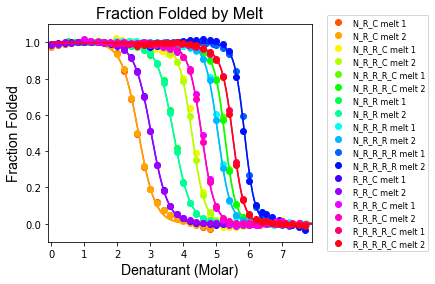

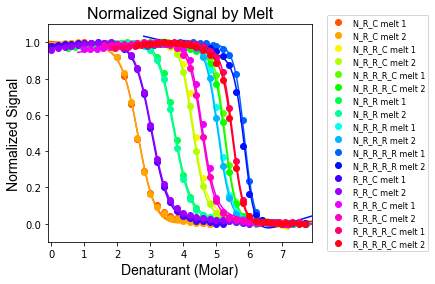

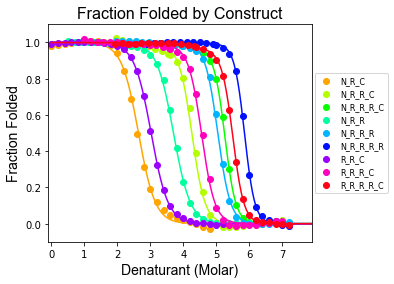

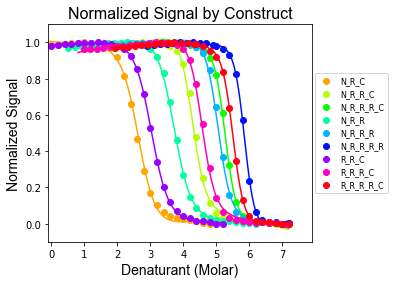

<function matplotlib.pyplot.clf>

In [2]:
print "\nPlotting results...\n"

# The function "baseline_adj" gives an adjusted y value based on fitted baseline 
# parameters (fraction folded). 
def baseline_adj(y, x, params, construct):
    af = result.params['af_{}'.format(construct)].value
    bf = result.params['bf_{}'.format(construct)].value
    au = result.params['au_{}'.format(construct)].value
    bu = result.params['bu_{}'.format(construct)].value
    return (y-(bu+(au*x)))/((bf+(af*x))-(bu+(au*x)))

# Defining global best-fit parameters
dGN = result.params['dGN'].value
dGR = result.params['dGR'].value
dGC = result.params['dGC'].value
dGinter =result.params['dGinter'].value
mi = result.params['mi'].value

# The function fit_model used for plotting best-fit lines and for adding  
# residuals to best-fit lines in bootstrapping.  Normalized, not frac folded.
def fit_model(params, x, melt):
    denat = x
    af = result.params['af_{}'.format(melt)].value
    bf = result.params['bf_{}'.format(melt)].value
    au = result.params['au_{}'.format(melt)].value
    bu = result.params['bu_{}'.format(melt)].value
    exec comp_frac_folded_dict[melt[:-2] + '_comp_ff'] # :-2 leaves off the _1, _2, etc from melt id.    
    return ((af * denat) + bf) * frac_folded + (((au * denat) + bu) * \
            (1 - frac_folded))   

# Finding the maximum denaturant value out of all the melts to
# set x axis bound
denat_maxer = np.zeros(0)
for melt in melts:
    denat_maxer = np.concatenate((denat_maxer, melt_data_dict[melt][:, 0]))
denat_maxer_list = denat_maxer.tolist()
denat_max = float(max(denat_maxer_list))
denat_bound = np.around(denat_max, 1) + 0.2

# Denaturant values to use when evaluating fits.  Determines how smooth the
# fitted curve will be, based on the third value (300) in the argument below.
# I might keep using this for fraction_foldeed, but for nomralized baseline
# use a local set of points for each melt, so as not to extrapolate the 
# bselines too far.
denat_fit = np.linspace(0, denat_bound, 300)

#defining a dictionary using the first melt of each construct (construct_1)
#Move this to the plotting part, and why not do this for all constructs?
construct1_data_dict = {}
for construct in constructs:
    construct1_data_dict[construct] = np.load('{0}{1}.npy'.format(path, construct + '_1'))

# The four dictionaries below define lower and upper denaturant limnits to be
# used for plotting normalized curves, so crazy-long baseline extrapolations 
# are not shown.  Do both for melts and construct 1.   These are then used
# to create 300-point synthetic baselines in the fifth and sixth dictionaries.
melt_lower_denat_dict = {}
for melt in melts:
    melt_lower_denat_dict[melt] = round(float(min(melt_data_dict[melt][:,0]))) -0.2

melt_upper_denat_dict = {}
for melt in melts:
    melt_upper_denat_dict[melt] = round(float(max(melt_data_dict[melt][:,0]))) + 0.2

construct1_lower_denat_dict = {}
for construct in constructs:
    construct1_lower_denat_dict[construct] = round(float(min(construct1_data_dict[construct][:,0]))) - 0.2

construct1_upper_denat_dict = {}
for construct in constructs:
    construct1_upper_denat_dict[construct] = round(float(max(construct1_data_dict[construct][:,0]))) + 0.2

melt_denat_synthetic_dict = {}
for melt in melts:
    melt_denat_synthetic_dict[melt] = np.linspace(melt_lower_denat_dict[melt],
                             melt_upper_denat_dict[melt], 300)

construct1_denat_synthetic_dict = {}
for construct in constructs:
    construct1_denat_synthetic_dict[construct] = np.linspace(construct1_lower_denat_dict[construct],
                             construct1_upper_denat_dict[construct], 300)

''' Global Plot Aesthetics'''
# Defining how the plots are colored
num_melt_colors = num_melts
num_construct_colors = num_constructs
coloration = plt.get_cmap('hsv')


# Dictonary defining title font
title_font = {'family': 'arial',
        'color': 'black',
        'weight': 'normal',
        'size': 16}

# Dictionary defining label font
label_font = {'family': 'arial',
        'color': 'black',
        'weight': 'normal',
        'size': 14}

'''First Plot: Fraction Folded by Melt'''
#extracting the melt data and creating plot lines for each melt
colorset = 0 # counter to control color of curves and points
for melt in melts:   
    colorset = colorset + 1
    denat = melt_data_dict[melt][:,0]     # A numpy array of type str
    norm_sig = melt_data_dict[melt][:,1]  # A numpy array of type str
    denat = denat.astype(float) # A numpy array of type float
    norm_sig = norm_sig.astype(float) # A numpy array of type float
    y_adj = baseline_adj(norm_sig, denat, result.params, melt)
    y_fit = fit_model(result.params, denat_fit, melt)
    y_fit_adj = baseline_adj(y_fit, denat_fit, result.params, melt)
    plt.plot(denat, y_adj, 'o', color = coloration(colorset/num_melt_colors),
            label = melt[:-2] + ' melt ' + melt[-1])       
    plt.plot(denat_fit, y_fit_adj, '-', color = coloration(colorset/num_melt_colors))

#set axis limits
axes=plt.gca()
axes.set_xlim([-0.1, denat_bound])
axes.set_ylim([-0.1,1.1])
axes.set_aspect(5.5)

#lot aesthetics and labels
plt.legend(loc = 'center', bbox_to_anchor = (1.25, 0.5), fontsize=8)
plt.title('Fraction Folded by Melt', fontdict = title_font)
plt.xlabel('Denaturant (Molar)', fontdict = label_font)
plt.ylabel('Fraction Folded', fontdict = label_font)

#saving plot in individual doc
plt.savefig('{0}{1}_plot_frac_folded_by_melt'.format(path, proj_name),\
            dpi = 500, bbox_inches='tight')

#show plot in iPython window and then close
plt.show()
plt.close()
plt.clf

'''Second Plot: Normalized Signal by Melt'''
colorset = 0
for melt in melts:   
    colorset = colorset + 1
    denat = melt_data_dict[melt][:,0]     # A numpy array of type str
    norm_sig = melt_data_dict[melt][:,1]  # A numpy array of type str
    denat = denat.astype(float) # A numpy array of type float
    norm_sig = norm_sig.astype(float) # A numpy array of type float
    y_fit = fit_model(result.params, melt_denat_synthetic_dict[melt], melt)
    plt.plot(denat, norm_sig, 'o', color=coloration(colorset/num_melt_colors),
             label = melt[:-2] + ' melt ' + melt[-1]) 
    plt.plot(melt_denat_synthetic_dict[melt], y_fit, '-', \
             color=coloration(colorset/num_melt_colors))

#set axis limits
axes=plt.gca()
axes.set_xlim([-0.1, denat_bound])
axes.set_ylim([-0.1,1.1])
axes.set_aspect(5.5)

#plot aesthetics and labels
plt.legend(loc = 'center', bbox_to_anchor = (1.25, 0.5), fontsize=8)
plt.title('Normalized Signal by Melt', fontdict = title_font)
plt.xlabel('Denaturant (Molar)', fontdict = label_font)
plt.ylabel('Normalized Signal', fontdict = label_font)

#saving plot in individual doc
plt.savefig('{0}{1}_plot_normalized_by_melt'.format(path, proj_name),\
            dpi=500, bbox_inches='tight')

#show plot in iPython window and then close
plt.show()
plt.close()
plt.clf

'''Third Plot: Fraction Folded by Construct'''
colorset = 0
for construct in constructs:   
    colorset = colorset + 1
    denat = construct1_data_dict[construct][:,0]  # A numpy array of type str
    denat_line = construct1_data_dict[construct][:, 0]   # A numpy array of type str
    norm_sig = construct1_data_dict[construct][:, 1]  # A numpy array of type str
    denat = denat.astype(float) # A numpy array of type float
    denat_line = denat_line.astype(float) # A numpy array of type float
    norm_sig = norm_sig.astype(float) # A numpy array of type float
    y_adj = baseline_adj(norm_sig, denat_line, result.params, construct + '_1')
    y_fit = fit_model(result.params, denat_fit, construct + '_1')
    y_fit_adj = baseline_adj(y_fit, denat_fit, result.params, construct + '_1')
    plt.plot(denat, y_adj, 'o', \
             color=coloration(colorset/num_construct_colors), label = construct)       
    plt.plot(denat_fit, y_fit_adj, '-', \
             color=coloration(colorset/num_construct_colors))

#set axis limits
axes=plt.gca()
axes.set_xlim([-0.1, denat_bound])
axes.set_ylim([-0.1,1.1])
axes.set_aspect(5.5)

#plot aesthetics and labels
plt.legend(loc = 'center', bbox_to_anchor = (1.15, 0.5), fontsize=8)
plt.title('Fraction Folded by Construct', fontdict = title_font)
plt.xlabel('Denaturant (Molar)', fontdict = label_font)
plt.ylabel('Fraction Folded', fontdict = label_font)

#saving plot in individual doc
plt.savefig('{0}{1}_plot_frac_folded_by_construct'.format(path, proj_name),\
            dpi=500, bbox_inches='tight')

#show plot in iPython window and then close
plt.show()
plt.close()
plt.clf

'''Fourth Plot: Normalized Signal by Construct'''
colorset = 0
for construct in constructs:   
    colorset = colorset + 1
    denat = construct1_data_dict[construct][:,0]     # A numpy array of type str
    norm_sig = construct1_data_dict[construct][:,1]  # A numpy array of type str
    denat = denat.astype(float) # A numpy array of type float
    norm_sig = norm_sig.astype(float) # A numpy array of type float
    y_fit = fit_model(result.params, construct1_denat_synthetic_dict[construct], \
                      construct + '_1')
    plt.plot(denat, norm_sig, 'o', color = coloration(colorset/num_construct_colors),
             label = construct) 
    plt.plot(construct1_denat_synthetic_dict[construct], y_fit, '-', \
             color = coloration(colorset/num_construct_colors))

#set axis limits
axes=plt.gca()
axes.set_xlim([-0.1, denat_bound])
axes.set_ylim([-0.1,1.1])
axes.set_aspect(5.5)

#plot aesthetics and labels
plt.legend(loc = 'center', bbox_to_anchor = (1.15, 0.5), fontsize=8)
plt.title('Normalized Signal by Construct', fontdict = title_font)
plt.xlabel('Denaturant (Molar)', fontdict = label_font)
plt.ylabel('Normalized Signal', fontdict = label_font)

#saving plot in individual doc
plt.savefig('{0}{1}_plot_normalized_by_construct'.format(path, proj_name),\
            dpi=500, bbox_inches='tight')

#show plot in iPython window and then close
plt.show()
plt.close()
plt.clf

## Bootstrap analysis

Asks the user to input the number of bootstrap iterations.  Bootstrap parameters are stored in a list of lists (**bs_param_values**). After performing the specified number of iterations, bootstrapped thermodynamic parameters are written to a csv file.

Again, bootstrapping is meant to be performed after fitting above.  Otherwise, the data and the fit model will have to be re-imported, and the params list and objective function will need to be generated.  Just run the fit again if needed.

In this version, a two minute sleep command is built in every 50 bootstrap iterations to let things cool down.

In [29]:
'''BootStrap analysis'''
# Create list to store bootstrap iterations of values and define column titles
bs_param_values = []  
bs_param_values.append(['Bootstrap Iter', 'dGN', 'dGR', 'dGC', 'dGinter', 'mi', 
                        'redchi**2','bestchi**2'])   
#total number of bootstrap iterations 
bs_iter_tot = input("How many bootstrap iterations? ") 

# bs_iter_tot = 10  # You would use this if you did not want user input from screen
bs_iter_count = 0   # Iteration counter
fit_resid_index= len(fit_resid) - 1

y_fitted_dict = {}
# Dictionary of 'true' normalized y values from fit at each denaturant value. 
for melt in melts:
    denat = melt_data_dict[melt][:,0] # A numpy array of type str
    denat = denat.astype(float)       # A numpy array of type float
    y_fitted_dict[melt] = np.array(fit_model(result.params, denat, melt))

# Arrays to store bs fitted param values
dGN_vals = []
dGR_vals = []
dGC_vals = []
dGinter_vals = []
mi_vals = []

# Add residuals chosen at random (with replacement) to expected
# y values. Note-residuals are combined ACROSS melts.
for j in xrange(0, bs_iter_tot):   
    rand_resid_dict={}  # Clears the random data for each bootsterap iteration
    bs_iter_count = bs_iter_count + 1
    print("Bootstrap iteration {0} out of {1}".format(bs_iter_count, 
                               bs_iter_tot))
    
    for melt in melts:
        rand_resid =[]
        denat = melt_data_dict[melt][:,0] # A numpy array of type str
        denat = denat.astype(float)       # A numpy array of type float
        
        for x in range(0,len(denat)):  # Creastes a list of random residuals
            rand_int = np.random.randint(0, fit_resid_index)
            rand_resid.append(fit_resid[rand_int])  
 
        rand_resid_dict[melt] = np.array(rand_resid)
        y_bootstrap = y_fitted_dict[melt] + rand_resid_dict[melt]
        z_max,z_min = y_bootstrap.max(), y_bootstrap.min()
        melt_data_dict[melt][:, 1] = (y_bootstrap - z_min)/(z_max - z_min)
    
    bs_result = lmfit.minimize(objective, init_guesses)
    bs_chisqr = bs_result.chisqr
    bs_red_chisqr= bs_result.redchi
    
    dGN = bs_result.params['dGN'].value
    dGR = bs_result.params['dGR'].value
    dGC = bs_result.params['dGC'].value
    dGinter = bs_result.params['dGinter'].value
    mi = bs_result.params['mi'].value
    
    # Store each value in a list for plotting and for downstream statistical analysis
    dGN_vals.append(dGN)
    dGR_vals.append(dGR)
    dGC_vals.append(dGC)
    dGinter_vals.append(dGinter)
    mi_vals.append(mi)
    
    # Append bootstrapped global parameter values for ouput to a file
    bs_param_values.append([bs_iter_count, dGN, dGR, dGC, dGinter, mi, 
                            bs_red_chisqr,bs_chisqr])
    
    # Let the processer have a little break every 100 bs iterations.  Probably unnecessary
    if bs_iter_count % 50 == 0:
        print('Taking a break to cool down')
        time.sleep(120)
        
    
with open('{0}{1}_bootstrap_params.csv'.format(path, proj_name), "wb") as n:
    writer = csv.writer(n, delimiter = ',')
    writer.writerows(bs_param_values)
n.close()

How many bootstrap iterations? 1000
Bootstrap iteration 1 out of 1000
Bootstrap iteration 2 out of 1000
Bootstrap iteration 3 out of 1000
Bootstrap iteration 4 out of 1000
Bootstrap iteration 5 out of 1000
Bootstrap iteration 6 out of 1000
Bootstrap iteration 7 out of 1000
Bootstrap iteration 8 out of 1000
Bootstrap iteration 9 out of 1000
Bootstrap iteration 10 out of 1000
Bootstrap iteration 11 out of 1000
Bootstrap iteration 12 out of 1000
Bootstrap iteration 13 out of 1000
Bootstrap iteration 14 out of 1000
Bootstrap iteration 15 out of 1000
Bootstrap iteration 16 out of 1000
Bootstrap iteration 17 out of 1000
Bootstrap iteration 18 out of 1000
Bootstrap iteration 19 out of 1000
Bootstrap iteration 20 out of 1000
Bootstrap iteration 21 out of 1000
Bootstrap iteration 22 out of 1000
Bootstrap iteration 23 out of 1000
Bootstrap iteration 24 out of 1000
Bootstrap iteration 25 out of 1000
Bootstrap iteration 26 out of 1000
Bootstrap iteration 27 out of 1000
Bootstrap iteration 28 out o

Bootstrap iteration 228 out of 1000
Bootstrap iteration 229 out of 1000
Bootstrap iteration 230 out of 1000
Bootstrap iteration 231 out of 1000
Bootstrap iteration 232 out of 1000
Bootstrap iteration 233 out of 1000
Bootstrap iteration 234 out of 1000
Bootstrap iteration 235 out of 1000
Bootstrap iteration 236 out of 1000
Bootstrap iteration 237 out of 1000
Bootstrap iteration 238 out of 1000
Bootstrap iteration 239 out of 1000
Bootstrap iteration 240 out of 1000
Bootstrap iteration 241 out of 1000
Bootstrap iteration 242 out of 1000
Bootstrap iteration 243 out of 1000
Bootstrap iteration 244 out of 1000
Bootstrap iteration 245 out of 1000
Bootstrap iteration 246 out of 1000
Bootstrap iteration 247 out of 1000
Bootstrap iteration 248 out of 1000
Bootstrap iteration 249 out of 1000
Bootstrap iteration 250 out of 1000
Taking a break to cool down
Bootstrap iteration 251 out of 1000
Bootstrap iteration 252 out of 1000
Bootstrap iteration 253 out of 1000
Bootstrap iteration 254 out of 1000


Bootstrap iteration 452 out of 1000
Bootstrap iteration 453 out of 1000
Bootstrap iteration 454 out of 1000
Bootstrap iteration 455 out of 1000
Bootstrap iteration 456 out of 1000
Bootstrap iteration 457 out of 1000
Bootstrap iteration 458 out of 1000
Bootstrap iteration 459 out of 1000
Bootstrap iteration 460 out of 1000
Bootstrap iteration 461 out of 1000
Bootstrap iteration 462 out of 1000
Bootstrap iteration 463 out of 1000
Bootstrap iteration 464 out of 1000
Bootstrap iteration 465 out of 1000
Bootstrap iteration 466 out of 1000
Bootstrap iteration 467 out of 1000
Bootstrap iteration 468 out of 1000
Bootstrap iteration 469 out of 1000
Bootstrap iteration 470 out of 1000
Bootstrap iteration 471 out of 1000
Bootstrap iteration 472 out of 1000
Bootstrap iteration 473 out of 1000
Bootstrap iteration 474 out of 1000
Bootstrap iteration 475 out of 1000
Bootstrap iteration 476 out of 1000
Bootstrap iteration 477 out of 1000
Bootstrap iteration 478 out of 1000
Bootstrap iteration 479 out 

Bootstrap iteration 677 out of 1000
Bootstrap iteration 678 out of 1000
Bootstrap iteration 679 out of 1000
Bootstrap iteration 680 out of 1000
Bootstrap iteration 681 out of 1000
Bootstrap iteration 682 out of 1000
Bootstrap iteration 683 out of 1000
Bootstrap iteration 684 out of 1000
Bootstrap iteration 685 out of 1000
Bootstrap iteration 686 out of 1000
Bootstrap iteration 687 out of 1000
Bootstrap iteration 688 out of 1000
Bootstrap iteration 689 out of 1000
Bootstrap iteration 690 out of 1000
Bootstrap iteration 691 out of 1000
Bootstrap iteration 692 out of 1000
Bootstrap iteration 693 out of 1000
Bootstrap iteration 694 out of 1000
Bootstrap iteration 695 out of 1000
Bootstrap iteration 696 out of 1000
Bootstrap iteration 697 out of 1000
Bootstrap iteration 698 out of 1000
Bootstrap iteration 699 out of 1000
Bootstrap iteration 700 out of 1000
Taking a break to cool down
Bootstrap iteration 701 out of 1000
Bootstrap iteration 702 out of 1000
Bootstrap iteration 703 out of 1000


Bootstrap iteration 901 out of 1000
Bootstrap iteration 902 out of 1000
Bootstrap iteration 903 out of 1000
Bootstrap iteration 904 out of 1000
Bootstrap iteration 905 out of 1000
Bootstrap iteration 906 out of 1000
Bootstrap iteration 907 out of 1000
Bootstrap iteration 908 out of 1000
Bootstrap iteration 909 out of 1000
Bootstrap iteration 910 out of 1000
Bootstrap iteration 911 out of 1000
Bootstrap iteration 912 out of 1000
Bootstrap iteration 913 out of 1000
Bootstrap iteration 914 out of 1000
Bootstrap iteration 915 out of 1000
Bootstrap iteration 916 out of 1000
Bootstrap iteration 917 out of 1000
Bootstrap iteration 918 out of 1000
Bootstrap iteration 919 out of 1000
Bootstrap iteration 920 out of 1000
Bootstrap iteration 921 out of 1000
Bootstrap iteration 922 out of 1000
Bootstrap iteration 923 out of 1000
Bootstrap iteration 924 out of 1000
Bootstrap iteration 925 out of 1000
Bootstrap iteration 926 out of 1000
Bootstrap iteration 927 out of 1000
Bootstrap iteration 928 out 

## The next cell calculates statistical properties of bootstrap parameters and outputs a file

I plan to merge this with the bootstrap cell, but it is much more convenient to code it separately.  

The structure that currently holds the bootstrap parameter values (*bs_param_values*) is a list of lists.  So it needs to be converted to a numpy array, and it needs to have only values, not column heads, in order to do numerical calculations.  Pandas would clearly be the right way to go with this, but not today.

*path* (for writing out the data frame) is taken from the fitting cell above.

In [30]:
import pandas as pd

bs_param_values_fullarray = np.array(bs_param_values)
bs_param_values_array = bs_param_values_fullarray[1:,1:-2].astype(np.float) # End at -2 since last two columns
                                                                            # are chi square statistics

bs_param_names = bs_param_values_fullarray[0][1:-2]

statistics = ['mean','median','stdev','2.5% CI','16.6% CI','83.7% CI','97.5% CI']

bs_statistics_df = pd.DataFrame(columns = statistics)

i = 0
for param in bs_param_names:
    bs_statistics = []
    bs_statistics.append(np.mean(bs_param_values_array[:,i]))
    bs_statistics.append(np.median(bs_param_values_array[:,i]))
    bs_statistics.append(np.std(bs_param_values_array[:,i]))
    bs_statistics.append(np.percentile(bs_param_values_array[:,i],2.5))
    bs_statistics.append(np.percentile(bs_param_values_array[:,i],16.7))
    bs_statistics.append(np.percentile(bs_param_values_array[:,i],83.3))
    bs_statistics.append(np.percentile(bs_param_values_array[:,i],97.5))
    bs_statistics_df.loc[param] = bs_statistics
    i = i + 1

bs_statistics_df.to_csv('{}{}_bootstrap_stats.csv'.format(path,proj_name))

corr_coef_matrix = np.corrcoef(bs_param_values_array, rowvar = False)
corr_coef_df = pd.DataFrame(corr_coef_matrix, columns = bs_param_names, index = bs_param_names)
corr_coef_df.to_csv('{}{}_bootstrap_corr_coefs.csv'.format(path,proj_name))

In [31]:
bs_statistics_df

,mean,median,stdev,2.5% CI,16.6% CI,83.7% CI,97.5% CI
dGN,5.404240,5.405437,0.062344,5.280005,5.344081,5.465290,5.523869
dGR,4.543896,4.545990,0.059763,4.427610,4.482736,4.600680,4.656946
dGC,7.014095,7.013228,0.074514,6.866948,6.943547,7.087606,7.156617
dGinter,-11.580746,-11.580734,0.120983,-11.814147,-11.701543,-11.464173,-11.338093
mi,0.778157,0.777946,0.007283,0.764355,0.770858,0.785593,0.791550


In [32]:
corr_coef_matrix

array([[ 1.        ,  0.94083767,  0.94950157, -0.9670477 ,  0.82608605],
       [ 0.94083767,  1.        ,  0.91650092, -0.94410937,  0.72144064],
       [ 0.94950157,  0.91650092,  1.        , -0.98118563,  0.89092329],
       [-0.9670477 , -0.94410937, -0.98118563,  1.        , -0.90683465],
       [ 0.82608605,  0.72144064,  0.89092329, -0.90683465,  1.        ]])

In [33]:
corr_coef_df

,dGN,dGR,dGC,dGinter,mi
dGN,1.000000,0.940838,0.949502,-0.967048,0.826086
dGR,0.940838,1.000000,0.916501,-0.944109,0.721441
dGC,0.949502,0.916501,1.000000,-0.981186,0.890923
dGinter,-0.967048,-0.944109,-0.981186,1.000000,-0.906835
mi,0.826086,0.721441,0.890923,-0.906835,1.000000


## Bootstrap histograms and correlation plots

Plots are generated for the thermodynamic parameters of interest (currently, baseline parameters are not included, thought this would not be hard to generate).  Histograms are generated for each parameter.  Scatter plots are generated for each pair of parameters (not including self-correlation) and arrayed in a grid along with a linear fit.  Shared axes are used in the grid to minimize white-space resulting from labelling each axis.  Thinking about the output as a matrix, the histograms are on the main diagonal, and the correllation plots are off-diagonal elements populating the upper triangle of the matrix.

The plot grid is dumped to the screen below, and is also written as a pdf file.

As with the plotting and bootstrapping scripts above, this is meant to be run after the fitting script (and after the bootstrapping script immediately above).  If you have not done that, re-run fit and bootstrap.

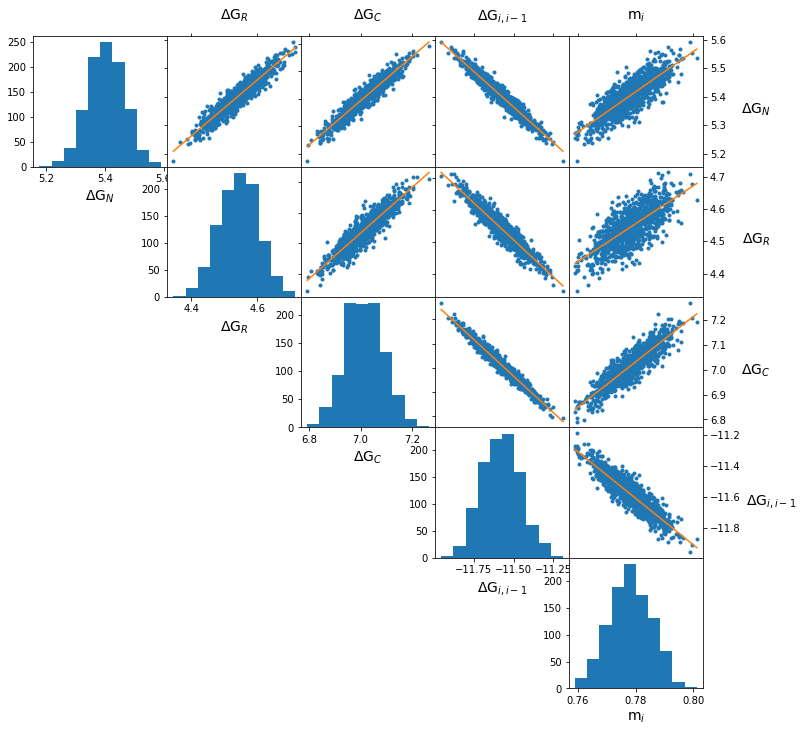

In [34]:
# Specify the names of parameters to be compared to see correlation.
corr_params = ['dGN', 'dGR', 'dGC', 'dGinter', 'mi']

# These are a second set of parameter names that follow in the same order
# as in corr_params.  They are formatted using TeX-style names so that Deltas 
# and subscripts will be plotted.  The would not be good key names for dictionaries
corr_param_labels = ['$\Delta$G$_N$', '$\Delta$G$_R$', '$\Delta$G$_C$', 
               '$\Delta$G$_{i, i-1}$', 'm$_i$']

num_corr_params = len(corr_params)
gridsize = num_corr_params  # Determines the size of the plot grid.

# Dictionary of fitted parameter values.
corr_params_dict = {'dGN': dGN_vals, 'dGR': dGR_vals, 'dGC': dGC_vals,\
                    'dGinter': dGinter_vals, 'mi': mi_vals}

# PDF that stores a grid of the correlation plots
with PdfPages('{0}{1}_Corr_Plots.pdf'.format(path, proj_name)) as pdf:
    fig, axs = plt.subplots(ncols=gridsize, nrows=gridsize, figsize=(12, 12))
    
    # Turns off axes on lower triangle
    axs[1, 0].axis('off')
    axs[2, 0].axis('off')
    axs[2, 1].axis('off')
    axs[3, 0].axis('off')
    axs[3, 1].axis('off')
    axs[3, 2].axis('off')
    axs[4, 0].axis('off')
    axs[4, 1].axis('off')
    axs[4, 2].axis('off')
    axs[4, 3].axis('off')

    # Defines the position of the y paramater from the array of params
    hist_param_counter = 0
    while hist_param_counter < num_corr_params:
        hist_param_label = corr_param_labels[hist_param_counter]
        hist_param = corr_params[hist_param_counter]
        # Start fixing labels here
        #plt.xticks(fontsize=8)
        #axs[hist_param_counter, hist_param_counter].tick_params(fontsize=8)
        #axs[hist_param_counter, hist_param_counter].yticks(fontsize=8)
        axs[hist_param_counter, hist_param_counter].hist(corr_params_dict[hist_param])
        axs[hist_param_counter, hist_param_counter].set_xlabel(hist_param_label,
                   fontsize=14, labelpad = 5)
        hist_param_counter = hist_param_counter + 1  
    
    # This part generates the correlation plots
    y_param_counter = 0
    while y_param_counter < num_corr_params - 1:
        # Pulls the parameter name for the y-axis label (with TeX formatting)
        yparam_label = corr_param_labels[y_param_counter]
        # Pulls the parameter name to be plotted on the y-axis
        yparam = corr_params[y_param_counter]
        
        # Defines the position of the x paramater from the array of params.
        # The + 1 offest avoids correlating a parameter with itself.
        x_param_counter = y_param_counter + 1
        
        while (x_param_counter < num_corr_params):
            #pulls the parameter name for the x-axis label (with TeX formatting)
            xparam_label = corr_param_labels[x_param_counter]
            # Pulls the parameter name to be plotted on the x-axis
            xparam = corr_params[x_param_counter]
            
            x_vals= corr_params_dict[xparam]
            y_vals = corr_params_dict[yparam]
            
            #plt.xticks(fontsize=8)
            #plt.yticks(fontsize=8)
            #plotting scatters with axes.  +1 shifts a plot to the right from main diagonal
            axs[y_param_counter, x_param_counter].plot(x_vals, y_vals, '.')
            
            # The if statement below turns off numbers on axes if not the right column and
            # not the main diagonal.
            if x_param_counter < num_corr_params - 1:
                axs[y_param_counter, x_param_counter].set_xticklabels([])
                axs[y_param_counter, x_param_counter].set_yticklabels([])
                           
            if y_param_counter == 0:  # Puts labels above axes on top row
                axs[y_param_counter, x_param_counter].xaxis.set_label_position('top')
                axs[y_param_counter, x_param_counter].set_xlabel(xparam_label,
                   labelpad = 10, fontsize=14)
                axs[y_param_counter, x_param_counter].xaxis.tick_top()
                if x_param_counter < num_corr_params - 1:  # Avoids eliminating y-scale from upper right corner
                    axs[y_param_counter, x_param_counter].set_yticklabels([])
           
            if x_param_counter == num_corr_params - 1:  #  Puts labels right of right column
                axs[y_param_counter, x_param_counter].yaxis.set_label_position('right')
                axs[y_param_counter, x_param_counter].set_ylabel(yparam_label, 
                   rotation = 0, labelpad = 30, fontsize=14)
                axs[y_param_counter, x_param_counter].set_xticklabels([])
                axs[y_param_counter, x_param_counter].yaxis.tick_right()
               
            # Determin correlation coefficient and display under subplot title
            # Note, there is no code that displays this value at the moment.
            #corr_coef = np.around(np.corrcoef(x_vals, y_vals), 3)
            
            #min and max values of the x param
            x_min = min(x_vals)
            x_max = max(x_vals)
            
            #fitting a straight line to the correlation scatterplot
            fit_array = np.polyfit(x_vals, y_vals, 1)
            fit_deg1_coef = fit_array[0]
            fit_deg0_coef = fit_array[1]      
            fit_x_vals = np.linspace(x_min, x_max, 10)
            fit_y_vals = fit_deg1_coef*fit_x_vals + fit_deg0_coef
            
            #plotting correlation line fits
            axs[y_param_counter, x_param_counter].plot(fit_x_vals, 
               fit_y_vals)
            plt.subplots_adjust(wspace=0, hspace=0)
            
            x_param_counter = x_param_counter + 1            
        y_param_counter = y_param_counter + 1
    
    pdf.savefig(bbox_inches='tight')